In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math
from spdm.data.Entry import open_entry


In [2]:
def plot_machine(device_name, entry):
    vessel_inner_points= np.array([ entry.wall.description_2d.vessel.annular.outline_inner.r(),
                                    entry.wall.description_2d.vessel.annular.outline_inner.z()]).transpose([1,0]) 

    vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r(),
                                    entry.wall.description_2d.vessel.annular.outline_outer.z()]).transpose([1,0])  


    tf_inner_points= np.array([entry.tf.coil.outline_inner.r(),entry.tf.coil.outline_inner.z()]).transpose([1,0]) 

    tf_outer_points= np.array([entry.tf.coil.outline_outer.r(),    
                                            entry.tf.coil.outline_outer.z()]).transpose([1,0])  

    limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r(),
                                    entry.wall.description_2d[0].limiter.unit[0].outline.z()]).transpose([1,0]) 

    fg=plt.figure()

    plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))

    plt.gca().add_patch(plt.Polygon(tf_inner_points , fill=False,closed=True,color="blue"))
    plt.gca().add_patch(plt.Polygon(tf_outer_points , fill=False,closed=True,color="blue"))

    plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True,color="green"))
    plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True,color="green"))


    for coil  in entry.pf_active.coil:
        rect=coil.element[0].geometry.rectangle.__value__() 
        plt.text(rect.r-rect.width/2.0, float(rect.z),str(coil.name))
        plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))

    psirz=entry.equilibrium.profiles_2d.psi()
    if len(psirz)>0:
        r, z = np.meshgrid(  entry.equilibrium.profiles_2d.grid.dim1(),
                            entry.equilibrium.profiles_2d.grid.dim2(), indexing='ij')
        plt.contour(r,z, psirz, levels= 30,linewidths=0.5)


    plt.gca().set_xlabel(r"Major radius $R$ [m]")
    plt.gca().set_ylabel(r"Height $Z$ [m]")
    plt.gca().set_title(device.upper())
    plt.axis('scaled')
    plt.show()


In [3]:
device="cfetr"
tree_name="cfetr"

entry =open_entry(f"{device}+mdsplus:///home/salmon/public_data/~t/?tree_name={tree_name}", shot=55555, time_slice=20)


2020-12-08 14:52:22,633 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.Plugincfetr#cfetrCollection
2020-12-08 14:52:22,635 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.PluginCfetr#CfetrCollection
2020-12-08 14:52:22,640 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: Found module : spdm.data.plugins.PluginCFETR#CFETRCollection
2020-12-08 14:52:22,642 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:88:find_plugin: Load Plugin: CFETRCollection
2020-12-08 14:52:22,671 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: Found module : spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-12-08 14:52:22,672 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:88:find_plugin: Load Plugin: MDSplusCollection
2020-12-08 14:52:2

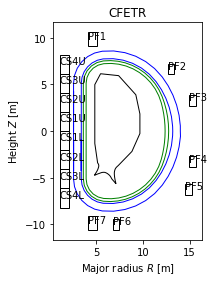

In [4]:
plot_machine(device,entry)

In [5]:
COIL=collections.namedtuple("COIL", "label r z current turns")
def psi(r, z, coils):
    def green_function(Rc, Zc, R, Z):
        k2   =  4.0*Rc*R/((Rc+R)*(Rc+R)+(Zc-Z)*(Zc-Z))          
        return   math.sqrt(R*Rc)/(2.0*math.pi)* ((2.0-k2) * special.ellipk(k2) - 2.0* special.ellipe(k2))/math.sqrt(k2)  
    return sum([green_function(coil.r, coil.z, r, z)*coil.current for coil in coils])

In [6]:
itime=30000

pf_coils=[] 
rpos=[]
zpos=[]
 
itime=40000
I0=[
    2,  #CS1U 
    5,  #CS2U
    5,  #CS3U
    6,  #CS4U
    2,  #CS4L
    2,  #CS3L
    2,  #CS2L
    1,  #CS1L
    1,  #PF1 
    -1, #PF2 
    1,  #PF3 
    1,  #PF4 
    -1, #PF5 
    0, #PF6 
    1   #PF7 
    ]
for idx,coil in enumerate(entry.pf_active.coil): 
    rect=coil.element[0].geometry.rectangle.__value__()
    rpos.append(rect.r-rect.width/2.0)
    rpos.append(rect.r+rect.width/2.0)
    zpos.append(rect.z-rect.height/2.0)
    zpos.append(rect.z+rect.height/2.0)  
    pf_coils.append(COIL(coil.name.__value__(),
     rect.r*1.0,rect.z*1.0, I0[idx],  (coil.element[0].turns_with_sign*1 ) ))
    # pf_coils.append(COIL(rect.r*1.0,rect.z*1.0,Ic[idx] ) )

rmin=min(rpos)
rmax=max(rpos)
zmin=min(zpos)
zmax=max(zpos)
NX=100
NY=100
X, Y  = np.meshgrid(np.linspace(rmin, rmax, NX),np.linspace(zmin, zmax, NY))
Z=np.ndarray([NX,NY])
for ix in range(NX):
    for iy in range(NY):
        Z[ix,iy]=psi(X[ix,iy],Y[ix,iy],pf_coils)

IndexError: list index out of range

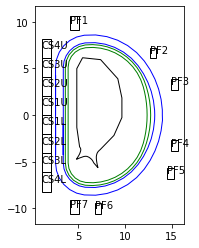

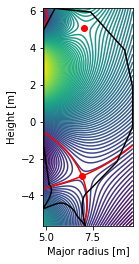

ValueError: No O-points found!

In [22]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__value__()
    
    coils.append((coil.name.__value__(), Coil(
                rect.r+rect.width/2, rect.z+rect.height/2, 
                turns=int(coil.element[0].turns_with_sign),
                # area=rect.width*rect.height,
                control=True
                )))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z())

CFETRTokamak = Machine(coils=coils,wall=wall)


eq = equilibrium.Equilibrium(tokamak=CFETRTokamak,
                                Rmin=min(wall.R),
                                Rmax=max(wall.R),
                                Zmin=min(wall.Z),
                                Zmax=max(wall.Z),
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)



# profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
#                             1e6,  # Plasma current [Amps]
#                             1.0)  # fvac = R*Bt

profiles = freegs.jtor.ConstrainPaxisIp(1e3, # Plasma pressure on axis [Pascals]
                                        1e5, # Plasma current [Amps]
                                        1.0) # fvac = R*Bt


# psivals = [ (R, Z, 0.0) for R, Z in zip(wall.R,wall.Z)]
# # psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
# #             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]

xpoints = [(7, -3),   # (R,Z) locations of X-points
           (7,5)]

isoflux = [(5.1,0, 7.8,0)] # (R1,Z1, R2,Z2) pair of locations

constrain = freegs.control.constrain(xpoints=xpoints,isoflux=isoflux)
freegs.solve(eq, profiles,constrain,maxits=500,show=True)



In [6]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True,color="blue"))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True,color="red"))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True,color="red"))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.text(rect.r-rect.width/2.0, float(rect.z),str(coil.name))
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
for label,coil  in coils:       
    plt.gca().add_patch(plt.Rectangle((coil.R, coil.Z), 0.1,0.1, fill=False))
 
plt.contour(np.linspace(rmin,rmax,129),np.linspace(zmin,zmax,129),eq.psi().transpose(-1,0),levels= 40,linewidths=0.5)

# plt.contour(X,Y,Z,levels=140,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     levels= 20,
#     linewidths=0.5)

plt.axis('scaled')
plt.show()

NameError: name 'coils' is not defined